# Performance, profiling
### iteration and parallelization
9 July 2021<br>
NRSC 7657<br>
Daniel J Denman and John Thompson<br>
University of Colorado Anschutz<br>
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys,glob
import time

### iteration

Serial exectution of cells 

In [5]:
a = 2

In [6]:
b= 2

In [7]:
c = a + b

Serial execution of some lines, through iteration     

In [8]:
for i in range(10):
    c=a+b + i
    print(i)


0
1
2
3
4
5
6
7
8
9


Serial execution of the same lines in the iteration, done in cells

In [9]:
print(0)

0


In [10]:
print(1)

1


In [11]:
print(2)

2


In [12]:
print(3)

3


In [13]:
print(4)

4


In [14]:
print(5)

5


In [15]:
print(6)

6


In [16]:
print(7)

7


In [17]:
print(8)

8


In [18]:
print(9)

9


# Performance
you will likely notice that some code is slow. for example:

In [19]:
for i in range(100):
    for j in range(100):
        a= 4
        time.sleep(0.002)

This is slow because we made it slow, with a `sleep()` call that pauses the execution of code for 2 msec every iteration. <br><br>
I am sure you all know and maybe have code of your own that is also slow. That is especially the nature of the beast if you are serially iterating over large amount of data (which can be ephys traces, images, or large matrices such as Seq data). Here we'll try to do some stuff with some ephys data, but many of the same principles apply

In [2]:
df = pd.read_csv('cluster_info.tsv',sep='\t')

In [3]:
df.head()

,id,Amplitude,ContamPct,KSLabel,amplitude,channel,depth,firing_rate,group,n_spikes,shank
0,0,31.8,100.0,mua,1.845319,0,20.0,0.3 spk/s,NaN,1833,0
1,1,50.5,100.0,mua,2.312337,1,20.0,3.4 spk/s,noise,20244,0
2,2,32.2,100.0,mua,2.041949,3,40.0,2.6 spk/s,NaN,15763,0
3,3,40.9,0.8,good,3.062917,1,20.0,8.2 spk/s,good,49401,0
4,4,28.7,100.0,mua,1.955942,5,60.0,3.5 spk/s,NaN,21074,0


In [4]:
#make it huge so it takes time, for demonstration
df = pd.concat([df]*10000,ignore_index=True)

In [23]:
df.head()

,id,Amplitude,ContamPct,KSLabel,amplitude,channel,depth,firing_rate,group,n_spikes,shank
0,0,31.8,100.0,mua,1.845319,0,20.0,0.3 spk/s,NaN,1833,0
1,1,50.5,100.0,mua,2.312337,1,20.0,3.4 spk/s,noise,20244,0
2,2,32.2,100.0,mua,2.041949,3,40.0,2.6 spk/s,NaN,15763,0
3,3,40.9,0.8,good,3.062917,1,20.0,8.2 spk/s,good,49401,0
4,4,28.7,100.0,mua,1.955942,5,60.0,3.5 spk/s,NaN,21074,0


how many "cells" have an amplitude > 100 µV? let's iterate over the `df` serially:

In [24]:
cell_ids=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids.extend([df.id[i]])

In [25]:
len(cell_ids)

350000

how do we speed this iteration up? our list of strategies:
- Sorting tuples
- filtering
- Built-in methods
- List comprehension
- Avoiding it (but don’t try too hard unless you need to)

list comprehension

In [26]:
cell_ids_listcomp = 

In [27]:
len(cell_ids_listcomp)

350000

sorting

In [29]:
df.head()

,id,Amplitude,ContamPct,KSLabel,amplitude,channel,depth,firing_rate,group,n_spikes,shank
0,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
1,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
2,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
3,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0
4,142,294.1,0.0,good,6.455642,77,780.0,17.3 spk/s,NaN,104315,0


In [43]:
len(cell_ids_sort)

3500

filtering (and built-ins)

In [31]:
df_cell_ids_filter =

In [32]:
len(df_cell_ids_filter)

350000

## all of those approaches do the job
and all produce the same resullt, but some seem to do it faster. how much faster?
<br>

# Profiling 
To figure out what is taking a long time, we do what is called "profiling". This is a like debugging, but instead of _"is this bit of code broken?"_ the question is _"how long does this bit of code take?"_
<br><br>
This is something that jupyter is designed to naturally highlight. we already have a feeling for this. instead of a script that did the above, which might look something like this:

In [ ]:
#serial
cell_ids=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids.extend([df.id[i]])
        
#list comprehension
cell_ids_listcomp = [df.id[i] for i in range(df.shape[0]) if df.Amplitude[i] > 100.]

#sort
df.sort_values(by='Amplitude',inplace=True,ascending=False,ignore_index=True)
cell_ids_sort=[]
for i in range(df.shape[0]):
    if df.Amplitude[i] > 100.:
        cell_ids_sort.extend([df.id[i]])
    else: break

#built-in / filtering
df_cell_ids_filter = df[df.Amplitude > 100.].Amplitude

this cell, or a script that was executing the lines in this cell, would just silently take a long time. <br><br>
With a cell, you naturally break your code into small enough chunks that you can see what is happening as you go. This will also give you a _sense_ of what is slow code, but maybe not exactly how slow it is. 

To time things, there are several options, including the `time` module which has several counters and `timeit`. in jupyter the `%%time` and `%%timeit` magics do this

# Another example
### and on to parallel computing

In [16]:
# load some data
lfp_data = np.memmap('/Users/danieljdenman/data/autobahn/20211115_7212_ABC_g3/20211115_7212_ABC_g3_t0.imec2.lf.bin',
                    dtype=np.int16, mode='r')

In [17]:
lfp_data.shape[0]/385

7060702.0

In [18]:
lfp_data.reshape(385,int(lfp_data.shape[0]/385))

memmap([[  64,   37,   45, ...,   25,  -16,   -3],
        [ -14,   20,   -6, ...,  -84, -196, -151],
        [-197, -174, -254, ...,   15,   38,    8],
        ...,
        [   5,   13,    2, ...,   76,   87,   68],
        [  43,   61,   42, ..., -428, -476, -484],
        [-463, -450, -475, ..., -232, -220,    0]], dtype=int16)

In [19]:
lfp_data = lfp_data.reshape(385,int(lfp_data.shape[0]/385))[:384]

In [20]:
lfp_data.shape

(384, 7060702)

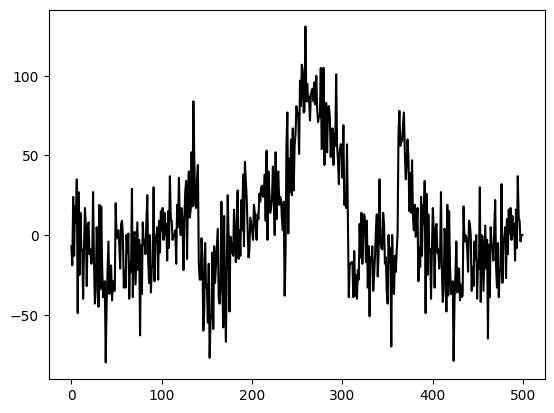

In [21]:
plt.plot(lfp_data[101,:500],'k')
# plt.plot(lfp_data[110,:500],'k',alpha=0.5)

In [22]:
chunk_of_lfp = lfp_data[:384,5000:10000]

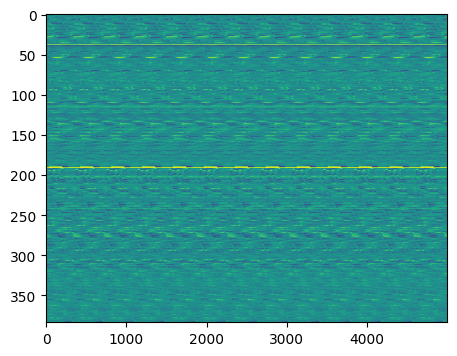

In [23]:
plt.figure(figsize=(10,4))
plt.imshow(chunk_of_lfp)
plt.gca().set_aspect(10)

In [24]:
mean_corrected = np.mean(chunk_of_lfp,1)
chunk_of_lfp = np.transpose(np.subtract(chunk_of_lfp.T, mean_corrected))

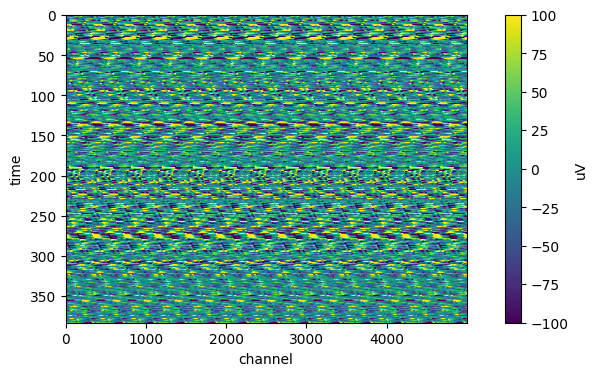

In [25]:
plt.figure(figsize=(10,4))
plt.imshow(chunk_of_lfp,clim=(-100,100))
plt.gca().set_aspect(10)
plt.ylabel('time')
plt.xlabel('channel')
plt.colorbar(label='uV')

In [26]:
np.shape(chunk_of_lfp)

(384, 5000)

can we find all the places where the deflection is greater than 100 µV in one time step, since these are likely to be outliers. 

In [27]:
# %%timeit
indexes = []
#one way to do this would be to iterate over the rows and columns:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))

### Informative progress printing
a way to build some intuition for what is taking so long is making sure your beefy iterations are always telling you what is going on. If you have your telling where it is and what the status is at some regularity, you might be able to check why things are taking so long. 
<br><br>
This is especially useful if you have a messy nested for loop (...which is fine, as long as it is not actually causing too much slow down for your _scientific_ progress)

In [58]:
np.shape(chunk_of_lfp)

(384, 5000)

In [29]:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            print('we are on row '+str(i)+' and column '+str(j))
            # print('we are on row '+str(i)+' and column '+str(j),end="\r")
            indexes.append((i,j))

we are on row 0 and column 4
we are on row 0 and column 377
we are on row 0 and column 381
we are on row 0 and column 382
we are on row 0 and column 383
we are on row 0 and column 389
we are on row 0 and column 759
we are on row 0 and column 766
we are on row 0 and column 767
we are on row 0 and column 768
we are on row 0 and column 774
we are on row 0 and column 1151
we are on row 0 and column 1152
we are on row 0 and column 1153
we are on row 0 and column 1159
we are on row 0 and column 1536
we are on row 0 and column 1537
we are on row 0 and column 1538
we are on row 0 and column 1544
we are on row 0 and column 1921
we are on row 0 and column 1922
we are on row 0 and column 1923
we are on row 0 and column 1929
we are on row 0 and column 2302
we are on row 0 and column 2306
we are on row 0 and column 2307
we are on row 0 and column 2308
we are on row 0 and column 2314
we are on row 0 and column 2691
we are on row 0 and column 2692
we are on row 0 and column 2693
we are on row 0 and c

use a built in:

In [ ]:
# %%timeit
np.where(np.abs(np.diff(chunk_of_lfp,axis=1))>100)[1].shape

14.2 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Parallel computing
`multiprocessing`, `joblib`, `asyncio`  and `dask`

In [1]:
#come with standard python
import multiprocessing, asyncio

In [5]:
import joblib, dask

Why so many? <br>
In most cases, any one of these packages could be used, and in many cases any one of them would speed up your code. As covered in the slides, each has it's own strengths: 
- `multiprocessing` and `joblib` are good for embarassingly parallel tasks, which are CPU-limited
- `asyncio` is most appropriate for I/O-limited, things that are slowed down by reading or writing from disk 
- `dask` is also good for CPU-limited; it is a little more tricky to implement than joblib, but has good integration with the packages you would use (`numpy`, `pandas`, `xarray`)
<br><br>
We go through an example with each one here, to compare them and build some intuition for when they might be useful. 
**note:** these are note the easiest packages to use; this is largely because of a design choice in python (the GIL) which tries to force things to run one at a time

<br>

`joblib`

In [6]:
from joblib import Parallel, delayed

In [7]:
from math import sqrt

In [8]:
%%timeit
[sqrt(i ** 2) for i in range(10)]

1.16 µs ± 14.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%%timeit
Parallel(n_jobs=12)(delayed(sqrt)(i ** 2) for i in range(10))

12.4 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try to speed up our finding of peaks in the ephys data<br>
as a reminder, we got a chunk of LFP data and it takes this long to do it with a nested loop (we're going to make it a little bigger chunk)

In [30]:
chunk_of_lfp = lfp_data[:384,5000:15000]

In [31]:
indexes = []
#one way to do this would be to iterate over the rows and columns:
for i in np.arange(0,np.shape(chunk_of_lfp)[0]):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))

We need to make our own function to pass to any parallel package, and an iterable to iterate over. it will dive the iterable over the "workers", have each worker use the function on its bit of the iterable, and collect the results:

In [32]:
def find_peaks(channel):
#     print(channel)
    indexes = []
    i=int(channel)
#     for i in tqdm.tqdm_notebook(np.arange(0,np.shape(chunk_of_lfp)[0]),desc="Channel Iteration"):
    for j in np.arange(1,np.shape(chunk_of_lfp)[1]):
        if np.abs(chunk_of_lfp[i][j] - chunk_of_lfp[i][j-1]) > 100:
            indexes.append((i,j))
#     print(i)
    return indexes

In [33]:
# %%time
indexes_p = Parallel(n_jobs=10)(delayed(find_peaks)(channel) for channel in np.arange(0,383))

<br>

<br>

<br>

<br>

`dask`

In [45]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=10, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.3:8787/status,
Dashboard: http://192.168.0.3:8787/status,Workers: 10
Total threads: 40,Total memory: 18.63 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.3/20915/1,Workers: 10
Dashboard: http://192.168.0.3:8787/status,Total threads: 40
Started: Just now,Total memory: 18.63 GiB
Comm: inproc://192.168.0.3/20915/4,Total threads: 4
Dashboard: http://192.168.0.3:55183/status,Memory: 1.86 GiB
Nanny: None,


In [46]:
import dask.array as da

In [47]:
x = da.from_array(chunk_of_lfp,chunks=100)

In [48]:
x

dask.array<array, shape=(384, 10000), dtype=int16, chunksize=(100, 100), chunktype=numpy.ndarray>

In [49]:
z = np.where(np.abs(np.diff(x,axis=1))>100)[1]
z

dask.array<getitem, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

In [50]:
# %%time
indexes_dask = z.compute()

In [18]:
np.shape(indexes_dask)

(15586,)

dask with pandas - mostly for really big Seq datasets, in the neuroscience context. would use dask.array for image or ephys data

serially with `pandas` takes a while

In [12]:
%%timeit
df_cell_ids_filter = df[df.Amplitude > 100.].Amplitude

47.7 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import dask.dataframe as dd

In [7]:
df.shape

(3370000, 11)

In [8]:
df_d = dd.from_pandas(df,npartitions = 500)

In [11]:
%%timeit
a = df_d[df_d.Amplitude > 100.].Amplitude

807 µs ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
df_cell_ids_filter=a.compute()

269 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
df_cell_ids_filter.shape

(350000,)

`multiprocessing`